In [34]:
import mne
import os
import autoreject as aj
import numpy as np
import pandas as pd

In [35]:
# Declaring the general path
path = os.path.join('C:/Users/annad/Documents/Thesis/Data/') 
subj_names = []

# Extracting subject name based on the file name
for x in os.listdir(path+'Post ICA/'):
    if 'raw.fif' in x:
        subj_names.append(x.split('_')[2])

print(subj_names)

['VP10', 'VP11', 'VP12', 'VP13', 'VP14', 'VP15', 'VP16', 'VP17', 'VP18', 'VP19', 'VP1', 'VP20', 'VP21', 'VP22', 'VP23', 'VP24', 'VP2', 'VP3', 'VP5', 'VP6', 'VP7', 'VP8', 'VP9']


In [36]:
# Merging the same events to a single sample number
def merge_events(events):
    events = mne.merge_events(events, [11,12,20,21,22,23,31,32], 11, replace_events=True) # stimulus/t1
    events = mne.merge_events(events, [64,65,66,67,68,128,129,130,131,132,133], 64, replace_events=True) # stimulus/t2
    events = mne.merge_events(events, [1,2,3], 1, replace_events=True) # response/t1
    events = mne.merge_events(events, [4,5], 4, replace_events=True) # response/t2
    events = mne.merge_events(events, [6,7], 6, replace_events=True) # block

    return events

In [37]:
# Decide if trial has a short or long SOA based on time difference of stimulus onsets
def find_condition(events):
    new_events = []
    existing_event_onsets_set1 = np.concatenate([events[events[:, 2] == 11, 0]]) # stimulus/t1
    existing_event_onsets_set2 = np.concatenate([events[events[:, 2] == 64, 0]]) # stimulus/t2
    
    for idx, x in enumerate(existing_event_onsets_set1):     
        # The time difference between the two stimuli is computed by finding for every stim1 the closest positive difference with all stim2
        diff = existing_event_onsets_set2 - x
        valid_indices = np.where(diff > 0)
        closest_index = np.argmin(diff[valid_indices])

        # Prevents error if there are more stimulus 1 events than stimulus 2 events
        if idx == len(existing_event_onsets_set2): break
        
        if diff[valid_indices][closest_index] > 600 and diff[valid_indices][closest_index] < 615: # to allow for some variation in the samples
            new_events.append([x, 0, 256])  # long delay
        elif diff[valid_indices][closest_index] > 140 and diff[valid_indices][closest_index] < 151:
            new_events.append([x, 0, 512])  # short delay
        else:
            new_events.append([x, 0, 1024])  # exclude
    return new_events

In [38]:
def get_events(raw, tmin, tmax):
    stimulus_id = {'stimulus/t1': 11, 'stimulus/t2': 64} # Stimulus trigger
    condition_id = {"condition/short": 512, "condition/long": 256} # Condition trigger
    response_id = {'response/t2': 4, 'response/t1': 1} # Response triggers
    event_id = condition_id | stimulus_id | response_id # All retained events

    events = mne.find_events(raw, shortest_event=1)
    events = merge_events(events)

    # Identify new events across trigger sets and consider only the two nearest events
    new_events = find_condition(events)
    new_events = np.array(new_events)
    events_temp = np.concatenate((events, new_events))

    # Get metadata and events
    metadata, events, event_id = mne.epochs.make_metadata(
        events=events_temp, event_id=event_id, tmin=tmin, tmax=tmax,
        sfreq=raw.info["sfreq"], row_events=list(stimulus_id.keys()), keep_first=["condition"])
    
    # Initialize trial index list and trial counter
    trial_indices = []
    trial_index = 0

    s1_indices = []
    s2_indices = []

    # Iterate through events and assign trial indices
    i = 0
    while i < len(events):
        if i < len(events) - 1 and ((events[i][2] == 11 and events[i + 1][2] == 64) or (events[i][2] == 64 and events[i + 1][2] == 11)):
            # Valid pair (11 -> 64 or 64 -> 11)
            trial_indices.append(trial_index)  # First event of the pair
            trial_indices.append(trial_index)  # Second event of the pair
            trial_index += 1  # Increment trial index for the next pair
            i += 2  # Move past the pair
        else:
            # Event doesn't form a valid pair, start a new trial for the next event
            trial_indices.append(trial_index)  # This event gets its own trial
            trial_index += 1  # Increment trial index for the next event
            i += 1  # Move to the next event
    
    metadata['trial_index'] = trial_indices

    for idx, e in enumerate(events):
        if e[2] == 11:
            s1_indices.append(idx)
        elif e[2] == 64:
            s2_indices.append(idx)

    return events, metadata, s1_indices, s2_indices

In [39]:
def get_events_2(raw, tmin, tmax):
    stimulus_id = {'stimulus/t1': 11, 'stimulus/t2': 64} # Stimulus trigger
    condition_id = {"condition/short": 512, "condition/long": 256} # Condition trigger
    response_id = {'response/t2': 4} # Response triggers
    event_id = condition_id | stimulus_id | response_id # All retained events

    events = mne.find_events(raw, shortest_event=1)
    events = merge_events(events)

    # Identify new events across trigger sets and consider only the two nearest events
    new_events = find_condition(events)
    new_events = np.array(new_events)
    events_temp = np.concatenate((events, new_events))

    # Get metadata and events
    metadata, events, event_id = mne.epochs.make_metadata(
        events=events_temp, event_id=event_id, tmin=tmin, tmax=tmax,
        sfreq=raw.info["sfreq"], row_events=list(response_id.keys()), keep_first=["condition"])
    
    s1_indices = []
    s2_indices = []
    for idx, e in enumerate(events):
        if e[2] != 11:
            continue

        if events[idx+1][2] == 64:
            s1_indices.append(idx)
            s2_indices.append(idx+1)
    
    return metadata, events, event_id, s1_indices, s2_indices

In [40]:
def create_epochs_t1(tmin, tmax, raw):
    events, metadata, s1_indices, _ = get_events(raw, tmin, tmax)
    metadata = metadata.iloc[s1_indices]
    # events = events[s1_indices]
    events = [events[i] for i in s1_indices]
    
    keep_cols = ['response/t1', 'first_condition', 'trial_index']
    metadata = metadata[keep_cols]
    metadata.reset_index(drop=True, inplace=True) # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
    metadata.columns = ['rt', 'condition', 'trial_index'] # More convenient names

    event_id = {'stimulus/t1': 11} # S1 will be the onset of the epochs

    # Create epochs
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                baseline=(None, 0), preload=True, 
                verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
                metadata=metadata, reject_by_annotation=True, reject=None)
    
    return epochs, events

In [41]:
def create_epochs_t2(tmin, tmax, raw):
    events, metadata, s1_indices, s2_indices = get_events(raw, tmin, tmax)
    metadata_2 = metadata.iloc[s1_indices]
    metadata = metadata.iloc[s2_indices]
    events = [events[i] for i in s2_indices]
    
    # Move up RTs of S2 based on short/long SOA because they are originally based on S1
    metadata_2['response/t2'] = np.where(metadata_2['first_condition']=='short', metadata_2['response/t2']-0.3, metadata_2['response/t2']-1.2)
    metadata['response/t2'] = metadata['response/t2'] - 0.024
    metadata.reset_index(drop=True, inplace=True)
    metadata_2.reset_index(drop=True, inplace=True)

    # Create a mapping from trial_index to first_condition from metadata_2 and update first_condition column in metadata only where trial_index matches
    update_map = metadata_2.set_index('trial_index')['first_condition']
    metadata['first_condition'] = metadata['trial_index'].map(update_map).fillna(metadata['first_condition'])

    update_map = metadata_2.set_index('trial_index')['response/t2']
    metadata['response/t2'] = metadata['trial_index'].map(update_map).fillna(metadata['response/t2'])
    
    keep_cols = ['response/t2', 'first_condition', 'trial_index']
    metadata = metadata[keep_cols]
    metadata.reset_index(drop=True, inplace=True) # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
    metadata.columns = ['rt', 'condition', 'trial_index'] # More convenient names

    event_id = {'stimulus/t2': 64} # S2 will be the onset of the epochs

    # Create epochs
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                baseline=(None, 0), preload=True, 
                verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
                metadata=metadata, reject_by_annotation=True, reject=None)
    
    return epochs, events

In [42]:
def create_epochs_trial(tmin, tmax, raw):
    events, metadata, s1_indices, _ = get_events(raw, tmin, tmax)
    metadata = metadata.iloc[s1_indices]
    # events = events[s1_indices]
    events = [events[i] for i in s1_indices]
    
    keep_cols = ['response/t2', 'first_condition', 'trial_index']
    metadata = metadata[keep_cols]
    metadata.reset_index(drop=True, inplace=True) # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
    metadata.columns = ['rt', 'condition', 'trial_index'] # More convenient names

    event_id = {'stimulus/t1': 11} # S1 will be the onset of the epochs

    # Create epochs
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                baseline=(None, 0), preload=True, 
                verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
                metadata=metadata, reject_by_annotation=True, reject=None)
    
    return epochs, events

In [43]:
def autoreject(epochs, raw):
    picks = mne.pick_types(raw.info, eeg=False, stim=False, eog=False, include=['C3', 'C4', 'POz', 'FCz'], exclude=[])
    ar = aj.AutoReject()
    
    # Fit on the first 20 epochs to save time
    ar.fit(epochs[0:20])
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)

    return epochs_ar

In [44]:
tmin = -0.25
tmax = 2

for subj in subj_names:
    # Skip those subjects because the data is not valid
    if subj == 'VP6' or subj == 'VP7':
        continue

    raw = mne.io.read_raw_fif(path+"Post ICA/post_ica_%s_raw.fif"%subj, preload=True)
    # epoch = mne.read_epochs(epoch_data_path+subj+'.fif')

    # ================= STIMULUS 1 =================
    # epochs, events = create_epochs_t1(tmin, tmax, raw)
    # epochs = autoreject(epochs, raw)
    # epochs.save(path+'Stimlocked_fixed_index/%s_epo_t1.fif'%subj, overwrite=True)

    # # ================= STIMULUS 2 =================
    epochs, events = create_epochs_t2(tmin, tmax, raw)
    epochs = autoreject(epochs, raw)
    epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)

    # ================= WHOLE TRIALS =================
    # epochs, events = create_epochs_trial(tmin, tmax, raw)
    # epochs = autoreject(epochs, raw)
    # epochs.save(path+'Stimlocked_fixed_index/%s_epo_trial.fif'%subj, overwrite=True)

Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP10_raw.fif...
    Range : 0 ... 2022399 =      0.000 ...  3949.998 secs
Ready.
Reading 0 ... 2022399  =      0.000 ...  3949.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6582 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  66  67 128 129
 130]
Adding metadata with 3 columns
1309 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1309 events and 1153 original time points ...
12 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1297 [00:00<?,       ?it/s]

Dropped 40 epochs: 14, 67, 83, 279, 334, 337, 358, 370, 414, 423, 455, 499, 548, 549, 582, 596, 620, 622, 623, 640, 746, 748, 758, 761, 810, 817, 852, 858, 866, 871, 919, 951, 952, 1022, 1086, 1088, 1093, 1101, 1155, 1273
Overwriting existing file.
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP10_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP11_raw.fif...
    Range : 0 ... 2158079 =      0.000 ...  4214.998 secs
Ready.
Reading 0 ... 2158079  =      0.000 ...  4214.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6497 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  65  66  67  68
 128 129 130 131]
Adding metadata with 3 columns
1268 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1268 events and 1153 original time points ...
11 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/1257 [00:00<?,       ?it/s]

Dropped 17 epochs: 238, 313, 392, 555, 556, 581, 606, 653, 686, 699, 810, 811, 1035, 1037, 1088, 1222, 1223
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP11_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP12_raw.fif...
    Range : 0 ... 2596351 =      0.000 ...  5070.998 secs
Ready.
Reading 0 ... 2596351  =      0.000 ...  5070.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6486 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  65  66  67  69
 128 129 130 131]
Adding metadata with 3 columns
1296 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1296 events and 1153 original time points ...
8 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/1288 [00:00<?,       ?it/s]

Dropped 502 epochs: 0, 2, 5, 6, 18, 19, 25, 26, 27, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 46, 48, 49, 53, 54, 60, 61, 63, 64, 71, 77, 87, 98, 102, 103, 104, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 27

C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP12_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP13_raw.fif...
    Range : 0 ... 2368511 =      0.000 ...  4625.998 secs
Ready.
Reading 0 ... 2368511  =      0.000 ...  4625.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6481 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  65 128 129 131]
Adding metadata with 3 columns
1285 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1285 events and 1153 original time points ...
5 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1280 [00:00<?,       ?it/s]

Dropped 16 epochs: 107, 530, 532, 533, 558, 559, 632, 637, 704, 813, 850, 851, 853, 1001, 1098, 1142
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP13_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP14_raw.fif...
    Range : 0 ... 1943039 =      0.000 ...  3794.998 secs
Ready.
Reading 0 ... 1943039  =      0.000 ...  3794.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6474 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  67 128 130 131
 133]
Adding metadata with 3 columns
1271 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1271 events and 1153 original time points ...
7 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1264 [00:00<?,       ?it/s]

Dropped 11 epochs: 95, 99, 487, 628, 632, 634, 798, 821, 950, 1159, 1160
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP14_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP15_raw.fif...
    Range : 0 ... 2025471 =      0.000 ...  3955.998 secs
Ready.
Reading 0 ... 2025471  =      0.000 ...  3955.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6478 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  20  21  22  31  32  64  65 128 129
 130]
Adding metadata with 3 columns
1280 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1280 events and 1153 original time points ...
5 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1275 [00:00<?,       ?it/s]

Dropped 8 epochs: 279, 315, 316, 322, 323, 328, 339, 1122
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP15_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP16_raw.fif...
    Range : 0 ... 1949183 =      0.000 ...  3806.998 secs
Ready.
Reading 0 ... 1949183  =      0.000 ...  3806.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6493 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64 128]
Adding metadata with 3 columns
1294 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1294 events and 1153 original time points ...
2 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1292 [00:00<?,       ?it/s]

Dropped 27 epochs: 248, 320, 471, 587, 616, 696, 712, 751, 752, 763, 795, 796, 820, 888, 890, 938, 943, 959, 1003, 1004, 1054, 1165, 1228, 1248, 1249, 1250, 1289
Overwriting existing file.
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP16_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP17_raw.fif...
    Range : 0 ... 2263551 =      0.000 ...  4420.998 secs
Ready.
Reading 0 ... 2263551  =      0.000 ...  4420.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6434 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  23  31  32  64  65  66  67
  68 128 129 130 131]
Adding metadata with 3 columns
1249 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1249 events and 1153 original time points ...
7 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1242 [00:00<?,       ?it/s]

Dropped 421 epochs: 25, 37, 43, 46, 47, 50, 51, 53, 54, 55, 59, 62, 64, 65, 66, 67, 68, 70, 72, 73, 75, 76, 77, 78, 80, 82, 88, 89, 90, 92, 93, 94, 95, 99, 101, 104, 105, 106, 107, 111, 112, 113, 116, 117, 119, 120, 121, 122, 124, 125, 130, 131, 132, 133, 134, 136, 137, 138, 141, 146, 148, 150, 155, 156, 157, 158, 159, 168, 169, 173, 175, 177, 178, 179, 185, 206, 211, 214, 215, 216, 217, 222, 226, 228, 229, 237, 238, 239, 240, 243, 248, 260, 261, 262, 269, 270, 271, 272, 273, 274, 278, 280, 281, 283, 285, 289, 298, 301, 302, 304, 307, 309, 311, 326, 333, 334, 337, 340, 352, 354, 357, 360, 364, 368, 378, 381, 382, 384, 385, 392, 393, 394, 403, 404, 410, 411, 421, 430, 433, 435, 437, 442, 443, 444, 446, 454, 455, 456, 457, 458, 460, 461, 462, 463, 464, 466, 467, 468, 469, 471, 472, 473, 474, 475, 476, 477, 480, 481, 482, 483, 485, 486, 488, 489, 490, 491, 492, 493, 494, 496, 497, 501, 503, 505, 506, 507, 508, 509, 510, 513, 516, 522, 529, 530, 533, 546, 547, 563, 565, 598, 610, 611, 624,

C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP17_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP18_raw.fif...
    Range : 0 ... 2062335 =      0.000 ...  4027.998 secs
Ready.
Reading 0 ... 2062335  =      0.000 ...  4027.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6469 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  65  67 128]
Adding metadata with 3 columns
1251 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1251 events and 1153 original time points ...
5 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1246 [00:00<?,       ?it/s]

Dropped 35 epochs: 204, 307, 324, 366, 423, 451, 498, 504, 523, 567, 568, 571, 572, 628, 727, 774, 817, 818, 837, 865, 866, 923, 924, 925, 926, 942, 965, 1030, 1031, 1032, 1033, 1074, 1075, 1231, 1232
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP18_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP19_raw.fif...
    Range : 0 ... 2519039 =      0.000 ...  4919.998 secs
Ready.
Reading 0 ... 2519039  =      0.000 ...  4919.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6489 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  66  67 128 129
 131]
Adding metadata with 3 columns
1293 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1293 events and 1153 original time points ...
5 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1288 [00:00<?,       ?it/s]

Dropped 34 epochs: 0, 1, 2, 3, 5, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 90, 91, 92, 95, 1269, 1270
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP19_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP1_raw.fif...
    Range : 0 ... 1836543 =      0.000 ...  3586.998 secs
Ready.
Reading 0 ... 1836543  =      0.000 ...  3586.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5397 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  18  21  22  31  32  64  65  66  67
 128 129 130 131 132 133]
Adding metadata with 3 columns
1070 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1070 events and 1153 original time points ...
10 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1060 [00:00<?,       ?it/s]

Dropped 91 epochs: 61, 62, 98, 109, 110, 152, 158, 160, 208, 209, 226, 253, 289, 358, 387, 414, 415, 416, 424, 429, 500, 501, 527, 531, 540, 543, 547, 548, 556, 557, 559, 560, 561, 562, 565, 568, 575, 583, 654, 688, 702, 723, 729, 735, 736, 743, 756, 757, 758, 762, 764, 767, 769, 774, 775, 778, 781, 782, 798, 801, 802, 821, 824, 830, 833, 834, 837, 838, 839, 841, 853, 854, 856, 872, 878, 879, 889, 892, 894, 933, 934, 948, 957, 958, 963, 973, 990, 998, 999, 1035, 1036
Overwriting existing file.
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP1_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP20_raw.fif...
    Range : 0 ... 2334207 =      0.000 ...  4558.998 secs
Ready.
Reading 0 ... 2334207  =      0.000 ...  4558.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6492 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  20  21  22  31  32  64  66 128 131]
Adding metadata with 3 columns
1280 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1280 events and 1153 original time points ...
8 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1272 [00:00<?,       ?it/s]

Dropped 83 epochs: 48, 174, 175, 242, 243, 255, 256, 272, 274, 288, 306, 316, 341, 361, 367, 380, 389, 407, 408, 432, 450, 452, 462, 512, 519, 535, 559, 618, 624, 628, 634, 657, 683, 717, 732, 733, 760, 765, 772, 798, 799, 800, 803, 816, 817, 826, 832, 843, 844, 846, 872, 874, 875, 885, 910, 923, 924, 926, 939, 952, 958, 962, 963, 968, 993, 994, 995, 1011, 1014, 1017, 1033, 1049, 1119, 1121, 1122, 1134, 1151, 1155, 1164, 1197, 1214, 1230, 1268
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP20_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP21_raw.fif...
    Range : 0 ... 2057727 =      0.000 ...  4018.998 secs
Ready.
Reading 0 ... 2057727  =      0.000 ...  4018.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6456 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  66  68 128 130]
Adding metadata with 3 columns
1244 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1244 events and 1153 original time points ...
3 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/1241 [00:00<?,       ?it/s]

Dropped 9 epochs: 192, 381, 516, 625, 805, 806, 876, 988, 1179
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP21_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP22_raw.fif...
    Range : 0 ... 2079743 =      0.000 ...  4061.998 secs
Ready.
Reading 0 ... 2079743  =      0.000 ...  4061.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6488 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64 128]
Adding metadata with 3 columns
1285 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1285 events and 1153 original time points ...
9 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1276 [00:00<?,       ?it/s]

Dropped 64 epochs: 31, 211, 304, 318, 330, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 768, 820, 850, 851, 852, 853, 854, 883, 907, 908, 909, 910, 922, 1054, 1055, 1056, 1062, 1078, 1134, 1170, 1174, 1180, 1181, 1185, 1186, 1248, 1252, 1274
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP22_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP23_raw.fif...
    Range : 0 ... 1972735 =      0.000 ...  3852.998 secs
Ready.
Reading 0 ... 1972735  =      0.000 ...  3852.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6481 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  65 128 129]
Adding metadata with 3 columns
1281 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1281 events and 1153 original time points ...
7 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1274 [00:00<?,       ?it/s]

Dropped 66 epochs: 30, 32, 36, 38, 63, 66, 75, 78, 141, 183, 184, 211, 262, 263, 264, 267, 269, 271, 272, 274, 275, 276, 277, 278, 282, 292, 298, 314, 425, 426, 427, 428, 434, 435, 491, 492, 501, 508, 551, 553, 639, 640, 664, 665, 666, 670, 679, 680, 687, 688, 689, 690, 693, 982, 983, 1058, 1059, 1060, 1061, 1083, 1084, 1101, 1149, 1207, 1208, 1209
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP23_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP24_raw.fif...
    Range : 0 ... 2479103 =      0.000 ...  4841.998 secs
Ready.
Reading 0 ... 2479103  =      0.000 ...  4841.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6470 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  65 128]
Adding metadata with 3 columns
1257 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1257 events and 1153 original time points ...
7 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/1250 [00:00<?,       ?it/s]

Dropped 38 epochs: 37, 95, 97, 174, 178, 198, 210, 213, 294, 295, 312, 365, 366, 497, 498, 569, 570, 619, 620, 622, 623, 634, 635, 672, 722, 731, 824, 870, 916, 918, 928, 1036, 1076, 1143, 1144, 1147, 1181, 1218
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP24_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP2_raw.fif...
    Range : 0 ... 2137599 =      0.000 ...  4174.998 secs
Ready.
Reading 0 ... 2137599  =      0.000 ...  4174.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6472 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  65  66 128 129
 130 131]
Adding metadata with 3 columns
1278 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1278 events and 1153 original time points ...
6 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1272 [00:00<?,       ?it/s]

Dropped 24 epochs: 72, 99, 100, 292, 293, 318, 319, 320, 356, 357, 409, 526, 527, 528, 674, 702, 713, 787, 825, 861, 896, 1200, 1218, 1261
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP2_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP3_raw.fif...
    Range : 0 ... 1845759 =      0.000 ...  3604.998 secs
Ready.
Reading 0 ... 1845759  =      0.000 ...  3604.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6495 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  67 128 129 130
 133]
Adding metadata with 3 columns
1274 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1274 events and 1153 original time points ...
7 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1267 [00:00<?,       ?it/s]

Dropped 21 epochs: 24, 101, 247, 346, 369, 390, 448, 449, 464, 493, 625, 683, 719, 768, 806, 807, 890, 1034, 1053, 1119, 1160
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP3_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP5_raw.fif...
    Range : 0 ... 1894911 =      0.000 ...  3700.998 secs
Ready.
Reading 0 ... 1894911  =      0.000 ...  3700.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6468 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  65  66  67 128
 129 130 131]
Adding metadata with 3 columns
1273 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1273 events and 1153 original time points ...
4 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1269 [00:00<?,       ?it/s]

Dropped 41 epochs: 24, 43, 44, 46, 57, 58, 59, 60, 67, 68, 74, 86, 89, 92, 99, 136, 141, 149, 156, 157, 162, 166, 168, 169, 170, 185, 197, 233, 234, 255, 256, 257, 309, 322, 336, 355, 371, 372, 490, 620, 1048
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP5_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.
Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP8_raw.fif...
    Range : 0 ... 1846272 =      0.000 ...  3606.000 secs
Ready.
Reading 0 ... 1846272  =      0.000 ...  3606.000 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5944 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  21  22  31  32  64  66 128 131]
Adding metadata with 3 columns
1181 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1181 events and 1153 original time points ...
9 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/1172 [00:00<?,       ?it/s]

Dropped 104 epochs: 8, 13, 26, 36, 37, 40, 103, 107, 115, 168, 173, 181, 185, 209, 214, 276, 290, 324, 330, 333, 335, 336, 365, 368, 386, 404, 432, 468, 478, 483, 502, 503, 527, 531, 535, 601, 625, 637, 641, 642, 643, 661, 680, 704, 709, 744, 812, 813, 834, 855, 859, 860, 870, 920, 928, 930, 931, 935, 936, 937, 938, 939, 948, 1035, 1036, 1039, 1040, 1041, 1045, 1047, 1065, 1068, 1069, 1089, 1090, 1091, 1101, 1113, 1114, 1115, 1116, 1118, 1119, 1120, 1122, 1126, 1131, 1135, 1136, 1140, 1141, 1142, 1143, 1145, 1150, 1151, 1154, 1160, 1161, 1162, 1163, 1164, 1165, 1167
Overwriting existing file.
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP8_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Opening raw data file C:/Users/annad/Documents/Thesis/Data/Post ICA/post_ica_VP9_raw.fif...
    Range : 0 ... 2112511 =      0.000 ...  4125.998 secs
Ready.
Reading 0 ... 2112511  =      0.000 ...  4125.998 secs...
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
6483 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6  11  12  16  20  21  22  31  32  64 128 129]
Adding metadata with 3 columns
1281 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1281 events and 1153 original time points ...
13 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.90 and n_interpolate=32


  0%|          | Repairing epochs : 0/1268 [00:00<?,       ?it/s]

Dropped 42 epochs: 26, 27, 31, 58, 63, 66, 74, 91, 98, 116, 123, 125, 126, 156, 161, 171, 184, 189, 208, 249, 296, 328, 350, 374, 385, 390, 416, 434, 447, 638, 662, 691, 713, 749, 812, 833, 869, 874, 877, 895, 918, 940
Overwriting existing file.


C:\Users\annad\AppData\Local\Temp\ipykernel_172744\2105183387.py:20: RuntimeWarning: This filename (C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/VP9_epo_t2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)


Overwriting existing file.


In [45]:
events_t1 = np.asarray(events_t1, dtype=np.float32)
events_t2 = np.asarray(events_t2, dtype=np.float32)

NameError: name 'events_t1' is not defined

In [ ]:
print("Task 1, visual stimulu, N300")
mne.grand_average(evoked_t1).plot(picks=['F3', 'F4'], hline=[0])

print("Task 2, auditory stimulu, P300")
mne.grand_average(evoked_t2).plot(picks=['AF3', 'AF4'], hline=[0])

print("Task 1, visual stimulu, PN300")
mne.grand_average(evoked_t1).plot(picks=['Fz', 'Cz'], hline=[0])

print("Task 2, auditory stimulu, PN300")
mne.grand_average(evoked_t2).plot(picks=['Fz', 'Cz'], hline=[0])

Task 1, visual stimulu, N300


ValueError: Please pass a list of Evoked or AverageTFR objects.

Identifying common channels ...
No projector specified for this dataset. Please consider the method self.add_proj.


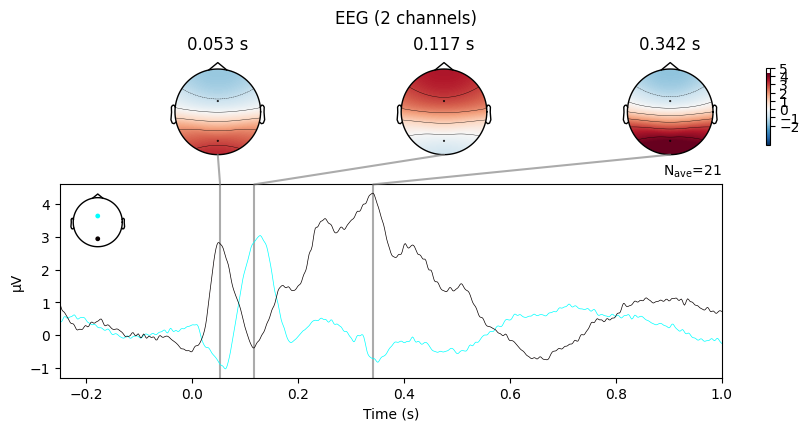

Identifying common channels ...
No projector specified for this dataset. Please consider the method self.add_proj.


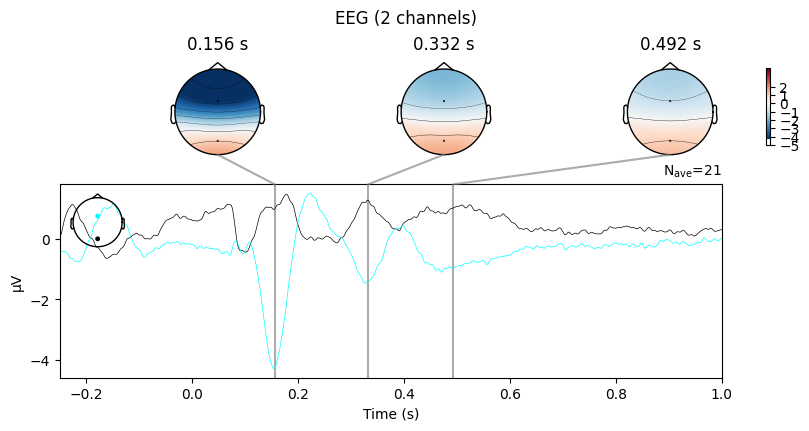

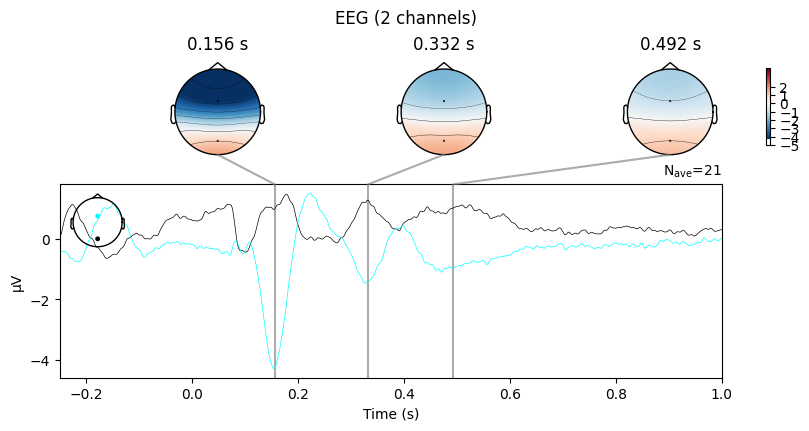

In [ ]:
mne.grand_average(evoked_t1).plot_joint(picks=['POz', 'FCz'])

mne.grand_average(evoked_t2).plot_joint(picks=['POz', 'FCz'])

In [7]:
def create_epochs(stimulus_id, response_id, tmin, tmax, raw):
    events = mne.find_events(raw, shortest_event=1)
    events = merge_events(events)

    # Identify new events across trigger sets and consider only the two nearest events
    new_events = find_condition(events, stimulus_id)
    new_events = np.array(new_events)
    events_temp = np.concatenate((events, new_events))

    condition_id = {"condition/short":512, "condition/long":256} #condition trigger
    stimulus_id_thingy = {'stimulus/t1':11}
    response_ids = {'response/t2':4, 'response/t1':1}
    event_id = condition_id | stimulus_id_thingy | response_ids #all retained events

    # get metadata and events
    metadata, events, event_id = mne.epochs.make_metadata(
        events=events_temp, event_id=event_id, tmin=tmin, tmax=tmax,
        sfreq=raw.info["sfreq"], row_events=list(stimulus_id_thingy.keys()), keep_first=["condition"])
    
    print(metadata)

    condition_id = {"condition/short":512, "condition/long":256} #condition trigger
    response_ids = {'response/t2':4, 'response/t1':1}
    stimulus_id_thingy = {'stimulus/t1':11, 'stimulus/t2':64}
    event_id = condition_id | stimulus_id_thingy | response_ids #all retained events

    metadata, events, event_id = mne.epochs.make_metadata(
        events=events_temp, event_id=event_id, tmin=tmin, tmax=tmax,
        sfreq=raw.info["sfreq"], row_events=list(stimulus_id_thingy.keys()), keep_first=["condition"])
    
    # print(metadata)
    what = metadata.loc[metadata['event_name'] == 'stimulus/t1']
    print(what)
    # what = what['first_condition'] != np.nan
    what['response/t2'] = np.where(what['first_condition']=='short', what['response/t2']-0.3, what['response/t2']-1.2)
    print(what)
    
    keep_cols = [list(response_id.keys())[0], 'first_condition']
    metadata = metadata[keep_cols]
    metadata.reset_index(drop=True, inplace=True)#This allows to preserve the trial number after the rejections performed by the mne.Epochs function
    metadata.columns = ['rt', 'condition']#More convenient names
    # metadata['rt'] = metadata['rt']

    # create epochs
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                baseline=(None, 0), preload=True, 
                verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
                metadata=metadata, reject_by_annotation=True, reject=None)
    
    return epochs, events_temp